In [93]:
import numpy as np
import matplotlib.pyplot as plt

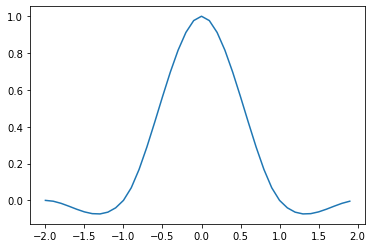

In [94]:
def get_cubic(offset):
    x = np.fabs(offset)
    if x<=1:
        return 1.5*x**3 - 2.5*x**2 + 1
    elif x<=2:
        return -0.5*x**3 + 2.5*x**2 - 4*x + 2
    return 0

arr = np.arange(-2,2,0.1)
arr2 = np.array([get_cubic(x) for x in arr])
plt.plot(arr,arr2)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

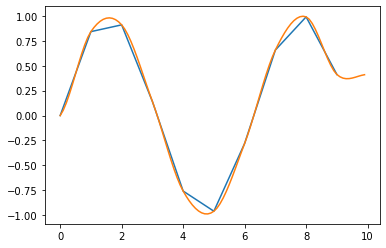

In [95]:
def cubic_interpo(src, pos):
    oy = int(pos)  # 取整
    dy = pos - oy # 取小数
    if dy == 0:
        return src[oy]
    grayValue = 0 # 初始化
    for n in range(-1,3): # 取-1,0,1,2
        k1 = get_cubic(dy - n) # 取插值系数
        oy2 = np.clip(oy + n, 0, len(src) - 1) # 取边界值
        grayValue += k1 * src[oy2] # 插值
    return grayValue # 返回插值结果

x = np.arange(0,  10,  1) 
y_sin = np.sin(x)

x2 = np.arange(0,10,0.1)
y_sin2 = np.array([cubic_interpo(y_sin, p) for p in x2])

plt.plot(x, y_sin)
plt.plot(x2, y_sin2)
plt.show

In [114]:
def bi_cubic_interpo(src, x, y):
    oy = int(y)
    dy = y - oy
    if dy == 0:
        return cubic_interpo(src[oy], x)
        
    grayValue = 0
    for n in range(-1, 3):
        k1 = get_cubic(dy - n)
        oy2 = np.clip(oy + n, 0, len(src) - 1)
        grayValue += k1 * cubic_interpo(src[oy2], x)
    return grayValue

def bi_cubic_interpo_y_cut(src, y):
    return np.array([bi_cubic_interpo(src, x, y) for x in range(len(src[0]))])

def bi_cubic_interpo_x_cut(src, x):
    return np.array([cubic_interpo(src[y], x) for y in range(len(src))])

# 1/step should be an integer
def bi_cubic_interpo_step(src, xstep, ystep):
    result = np.empty((int(len(src) / ystep+0.5), int(len(src[0]) / xstep+0.5)))
    # 每行按xstep插值
    for xi, xx in enumerate(np.arange(0, len(src[0]), xstep)):
        for y in range(0, len(src)):
            result[int(y / ystep + 0.5), xi] = cubic_interpo(src[y], xx)
    
    # 生成一个转置的副本
    tmp = np.transpose(result[::int(1/ystep+0.5), :])
    # 每列按ystep插值，由于行已经插值完成，只需在同一列的原间隔数组基础上插值即可
    for yi, yy in enumerate(np.arange(0, len(src), ystep)):
        for xi, xx in enumerate(np.arange(0, len(src[0]), xstep)):
            result[yi, xi] = cubic_interpo(tmp[xi], yy)
            #result[yi, xi] = cubic_interpo(result[::int(1/ystep+0.5), xi], yy)

    return result

In [97]:
def peaks(x, y):
    return 3*(1-x)**2*np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5)*np.exp(-x**2-y**2) - 1/3*np.exp(-(x+1)**2 - y**2)

In [98]:
x = np.arange(-3,3,1)
y = np.arange(-3,3,1)
x_2d, y_2d = np.meshgrid(x, y)
z = peaks(x_2d, y_2d)

x2 = np.arange(-3,3,0.1)
y2 = np.arange(-3,3,0.1)

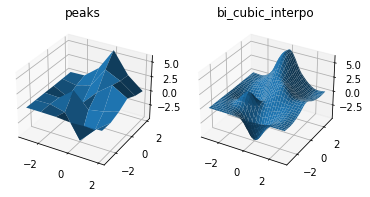

In [99]:
z2 = np.empty((len(y2), len(x2)))
for yi,yy in enumerate(y2):
    for xi,xx in enumerate(x2):
        z2[yi, xi] = bi_cubic_interpo(z, xx+3, yy+3) # 要转换坐标系的坐标

fig = plt.figure()

ax1 = fig.add_subplot(121, projection='3d')
ax1.title.set_text('peaks')
ax1.plot_surface(x_2d, y_2d, z)

x_2d2, y_2d2= np.meshgrid(x2, y2)
ax2 = fig.add_subplot(122, projection='3d')
ax2.title.set_text('bi_cubic_interpo')
ax2.plot_surface(x_2d2, y_2d2, z2)

plt.show()

2.2648549702353193e-14


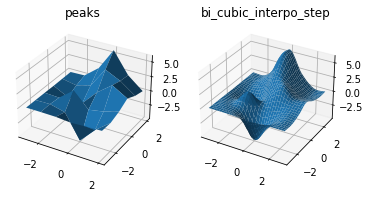

In [117]:
z3 = bi_cubic_interpo_step(z, 0.1, 0.1)

fig = plt.figure()

ax1 = fig.add_subplot(121, projection='3d')
ax1.title.set_text('peaks')
ax1.plot_surface(x_2d, y_2d, z)

x_2d2, y_2d2= np.meshgrid(x2, y2)
ax2 = fig.add_subplot(122, projection='3d')
ax2.title.set_text('bi_cubic_interpo_step')
ax2.plot_surface(x_2d2, y_2d2, z3)

print(np.fabs(z3-z2).max())

plt.show()

1.6431300764452317e-14
1.354472090042691e-14


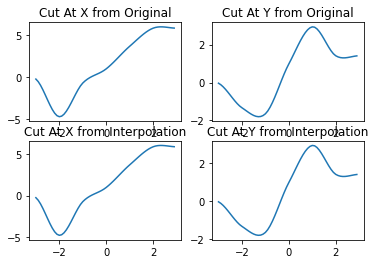

In [113]:
fig = plt.figure()

zx1 = bi_cubic_interpo_x_cut(z, 3)
zy1 = bi_cubic_interpo_y_cut(z, 3)
zx1 = np.array([cubic_interpo(zx1, p) for p in np.arange(0, len(zx1), 0.1)]) # 切出指定曲线再插值
zy1 = np.array([cubic_interpo(zy1, p) for p in np.arange(0, len(zy1), 0.1)])

zx2 = bi_cubic_interpo_x_cut(z2, 30)
zy2 = bi_cubic_interpo_y_cut(z2, 30)

ax1 = fig.add_subplot(221)
ax1.title.set_text('Cut At X from Original')
ax1.plot(y2, zx1)

ax1 = fig.add_subplot(222)
ax1.title.set_text('Cut At Y from Original')
ax1.plot(x2, zy1)

ax2 = fig.add_subplot(223)
ax2.title.set_text('Cut At X from Interpolation')
ax2.plot(y2, zx2)

ax2 = fig.add_subplot(224)
ax2.title.set_text('Cut At Y from Interpolation')
ax2.plot(x2, zy2)

# 对比，切出再插值与直接双向插值结果的差异
print(np.fabs(zx1-zx2).max())
print(np.fabs(zy1-zy2).max())

plt.show()